## Monte Carlo simulation of stable membrane curvatures

##### Using functions from mem_curve.py

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
import os
# For reading csv
import csv
import re

# Custom imports
from mem_curve import *

### Running simulation, replica exchange, annealing

#### Simulation:
Initialise model membrane, run Monte Carlo for <n> steps

#### Replica exchange:
Access surfaces otherwise separated by potential barriers...
Tune kbT factor up & down to alter acceptance ratio from equilibrium ensemble
Run parallel simulation windows, can swap replicas between kbT environments

#### Annealing:
Slowly return kbT factor to equilibrium
If too quick, will form "glass" -- initially all moves "downhill" & become trapped in metastable state space

In [3]:
# Choose number of Monte Carlo steps
nsteps = 5000

# Choose directory to save
save_dir = 'trial_l50_3'
os.makedirs(f'./{save_dir}/', exist_ok=True)

# Initialise membrane ensemble
membrane_lst = [init_model_membrane()]

In [4]:
# Track acceptance probability
naccepts      = 0
accepts_track = []

# Run simulation
for step in range(1,nsteps+1):
    
    membrane_lst, accept_move = montecarlostep(membrane_lst)
    
    naccepts += 1 if accept_move else 0
    accepts_track += [naccepts]
    
    if step%500==0 and step!=0:
        print(f'Step {step}: accepted moves {naccepts}')

print('Acceptance ratio:', naccepts/nsteps)

Step 500: accepted moves 484
Step 1000: accepted moves 956
Step 1500: accepted moves 1425
Step 2000: accepted moves 1882
Step 2500: accepted moves 2355
Step 3000: accepted moves 2830
Step 3500: accepted moves 3294
Step 4000: accepted moves 3766
Step 4500: accepted moves 4238
Step 5000: accepted moves 4712
Acceptance ratio: 0.9424


In [5]:
# Save data to a csv

df = pd.DataFrame(membrane_lst)

df.to_csv(f'./{save_dir}/model_membranes.csv', index=False)

In [12]:
# load data from saved csv

def string_to_array(s):
    s_clean = re.sub(r'[\[\]]', '', s)
    if ' ' not in s_clean:
        return float(s_clean)
    return np.array([[float(x) for x in line.split() if x]
                     for line in s_clean.strip().split('\n')])

with open(f'./{save_dir}/model_membranes.csv', mode='r', newline='') as file:
    reader = csv.DictReader(file)
    membrane_lst = []
    for row in reader:
        parsed_row = {}
        for key, val in row.items():
            parsed_row[key] = string_to_array(val)
        membrane_lst.append(parsed_row)

### Data Analysis

#### Equilibration

How does ratio of accepted moves evolve?

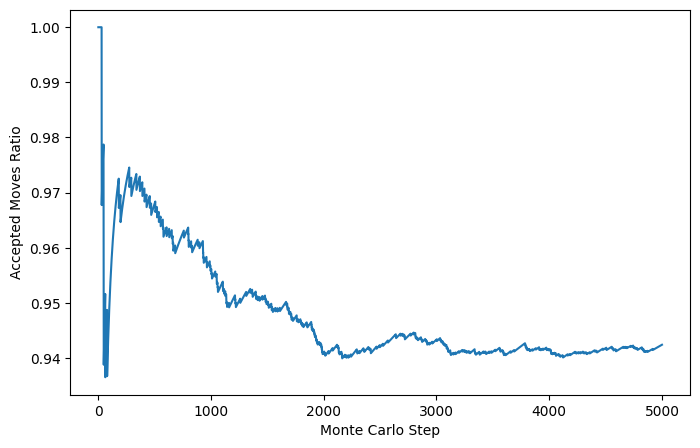

In [9]:
mcsteps_arr = np.linspace(1,nsteps,nsteps)
ratio_arr = np.array(accepts_track)/mcsteps_arr

plt.figure(figsize=[8,5])
plt.ylabel('Accepted Moves Ratio')
plt.xlabel('Monte Carlo Step')
plt.plot(mcsteps_arr, ratio_arr)
plt.savefig(f'./{save_dir}/naccepts.pdf')
plt.show()

#### Plot bending energy vs Monte Carlo step
#### Plot mean curvature vs Monte Carlo step
#### Plot Gaussian curvature vs Monte Carlo step
^ are these values expected? Are states stable &/ in equilibrium ensemble?

In [12]:
# Extract bending energy from membrane_lst of dictionaries
energy_lst = [ membrane['energy'] for membrane in membrane_lst ]

# Calculate values every <nframes>
nframes = 10

H_lst = []
K_lst = []

for membrane in membrane_lst[::nframes]:

    # Calculate shape operator
    S = calc_shape_operator(membrane, params.X, params.Y)
    # Calculate mean and Gaussian curvatures
    H_lst += [np.sum(calc_H(S))]
    K_lst += [np.sum(calc_K_G(S))] 

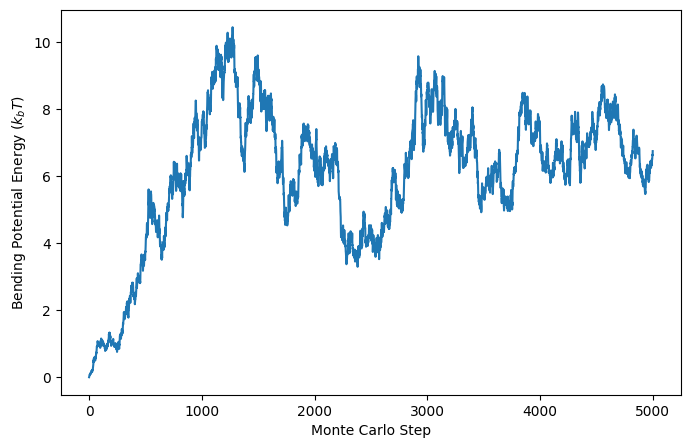

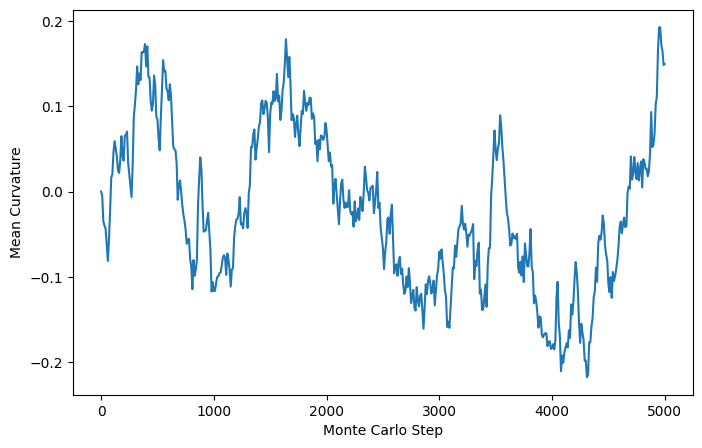

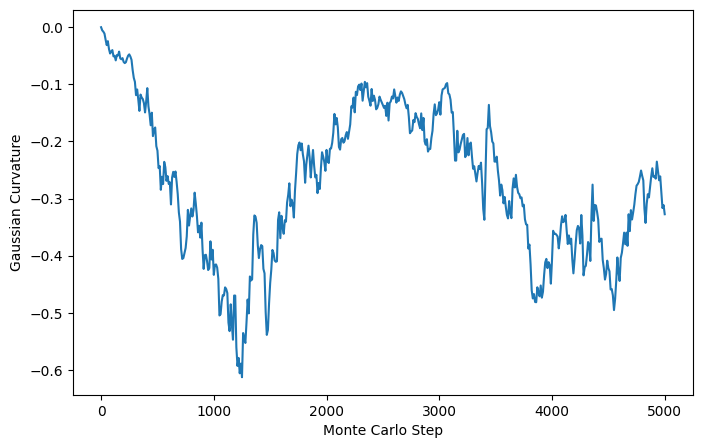

In [13]:
# Plot energy
plt.figure(figsize=[8,5])
plt.ylabel('Bending Potential Energy ($k_bT$)')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1), energy_lst)
plt.savefig(f'./{save_dir}/bending_energy.pdf')
plt.show()

# Plot mean curvature
plt.figure(figsize=[8,5])
plt.ylabel('Mean Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), H_lst)
plt.savefig(f'./{save_dir}/mean_curvature.pdf')
plt.show()

# Plot Gaussian curvature
plt.figure(figsize=[8,5])
plt.ylabel('Gaussian Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), K_lst)
plt.savefig(f'./{save_dir}/Gaussian_curvature.pdf')
plt.show()

#### Take mean of height (from equilibrium sampled region)
Is average membrane structure flat?

#### Take mean squared height
How does membrane thickness compare to CWT..?

$\langle h(\textbf{r})^{2} \rangle = \frac{k_bT}{16\pi^{3} \kappa} L^{2} $

In [8]:
# Skip steps before equilibrium
nskip = 2500

# Calculate values every <nframes>
nframes = 10

# Simulated values
mean_height   = 0 
meansq_height = 0 

for membrane in membrane_lst[nskip::nframes]:

    # Calculate height
    mem_height     = calc_height(membrane, params.X, params.Y)
    mean_height   += np.mean(mem_height) # average over all grids
    meansq_height += np.max(mem_height)**2 /2 + np.min(mem_height)**2 /2
    
mean_height   /= len(membrane_lst[nskip::nframes])
meansq_height /= len(membrane_lst[nskip::nframes])

# Theoretical value (from Capillary Wave Theory on membranes)
cwt_meansq_h = params.kbT / (16 * np.pi**3 * params.kappa_H) * params.l_x * params.l_y

In [9]:
print(f'''
<h> = {mean_height} (simulated)
<h> = 0.0 (CWT)

<h^2> = {meansq_height} (simulated) 
<h^2> = {cwt_meansq_h} (CWT)''')


<h> = 0.2995474679395912 (simulated)
<h> = 0.0 (CWT)

<h^2> = 0.2509943749632037 (simulated) 
<h^2> = 5.039302255187421 (CWT)


#### Visualising membrane curvature

In [ ]:
# Set plots as pop-ups
%matplotlib qt

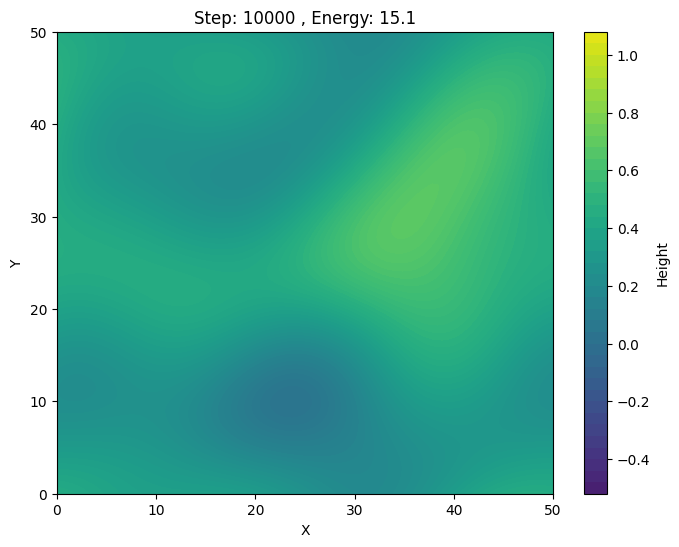

In [11]:
# Visualise membrane curvatures with contour plot movie
visualise(membrane_lst, nframes=50, save_dir=save_dir)

#### Save logging info

In [10]:
log_str = f'''
# # # Parameters # # #

Box parameters:
l_x       = {params.l_x}    # Box size, x-direction
l_y       = {params.l_y}    # Box size, y-direction
exp_order = {params.exp_order}     # Order of 2D Fourier expansion
npts      = {params.npts}   # Number of points in each X, Y for grid calculations

Bending energies:
H_0     = {params.H_0}     # Optimum mean curvature
kappa_H = {params.kappa_H}     # Bending modulus of mean curvature (kbT units)
kappa_K = {params.kappa_K}     # Bending modulus of Gaussian curvature (kbT units)

Size of Monte Carlo moves:
delta = {params.delta}     # Standard deviation of perturbation applied to Fourier coefficients

Number of steps:
nsteps = {nsteps}


# # # Results # # #

Acceptance ratio   = {naccepts/nsteps}

Curvature:
Bending energy     = {np.mean(energy_lst[int(nskip/nframes):])}
Mean curvature     = {np.mean(H_lst[int(nskip/nframes):])}
Guassian curvature = {np.mean(K_lst[int(nskip/nframes):])}

Membrane height:
mean height = {mean_height} (simulated)
mean height = 0.0                   (CWT)
mean squared height = {meansq_height} (simulated)
mean squared height = {cwt_meansq_h} (CWT)

Note: averages after {nskip} steps
'''

filename = f"./{save_dir}/log.txt"

# Write the string to the file
with open(filename, "w") as file:
    file.write(log_str)